 ## Preparing the Dataset
 First we download the dataset and some of the associated tools. Note: this part of the demo was quickly copy-pasted from the [data source's own demo notebook](https://github.com/effepivi/gvxr-CMPB/blob/main/1-gVirtualXRay_vs_Gate-detector_realistic_phantom.ipynb) so some of the install libraries and code below is likely unnecesarry, I will work to clean it up over time.

import os
import urllib

if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

files = ['https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/pediatric_phantom_data/labels.dat',
         'https://raw.githubusercontent.com/bnel1201/XCIST_demo/main/DICOM_to_voxelized_phantom.py']

for url in files:
    fname = url.split('main/')[1]
    if not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)

In [1]:
!pip install --upgrade --quiet SimpleITK pandas pydicom tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.


In [2]:
import zipfile
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

 ### Download and unzip the phantom dataset

In [3]:
if not os.path.exists("XCAT_data"):
    os.mkdir("XCAT_data")
if not os.path.exists("XCAT_data/Adult_Male_50percentile_Chest_Phantom_1700x1050x900.zip"):
    urllib.request.urlretrieve("https://github.com/xcist/phantoms-voxelized/raw/main/Adult_Male_50percentile_Chest_Phantom_1700x1050x900.zip", "XCAT_data/Adult_Male_50percentile_Chest_Phantom_1700x1050x900.zip")

    with zipfile.ZipFile("XCAT_data/Adult_Male_50percentile_Chest_Phantom_1700x1050x900.zip","r") as zip_ref:
        zip_ref.extractall("XCAT_data")

 ## Load the phantom into memory

 The data source used Simple ITK to read and write the phantom to memory, working with Simple ITK (sitk) is a lot different from Numpy and can take some getting used to, more information can be found here: https://simpleitk.org/SimpleITK-Notebooks/01_Image_Basics.html

 However, in this demo we load it immediately into a numpy object

In [5]:
!git clone https://github.com/xcist/main.git XCIST
!pip install --upgrade --quiet XCIST/

Cloning into 'XCIST'...
remote: Enumerating objects: 3524, done.
remote: Counting objects: 100% (3524/3524), done.
remote: Compressing objects: 100% (1781/1781), done.
remote: Total 3524 (delta 1747), reused 3458 (delta 1709), pack-reused 0
Receiving objects: 100% (3524/3524), 275.94 MiB | 30.05 MiB/s, done.
Resolving deltas: 100% (1747/1747), done.
  Preparing metadata (setup.py) ... done


In [8]:
import os
os.abs

In [9]:
import catsim as xc
from pathlib import Path
phantom_path = Path('adult_male_chest')
phantom_path.mkdir(exist_ok=True)
cfg_path = Path('cfg/adult_male_chest')
cfg_path.mkdir(exist_ok=True, parents=True)
with open(cfg_path / 'Phantom_male_adult.cfg', 'w') as f:
  f.write(f"""
# Phantom
phantom.callback = "Phantom_NURBS"      # name of function that reads and models phantom
phantom.projectorCallback = "C_Projector_Voxelized"  # name of function that performs projection through phantom
phantom.filename = "{phantom_path}/Adult_Male_50percentile_Chest_Phantom_1700x1050x900/adult_male_50percentile_chest.json"   # phantom filename
phantom.centerOffset = [0.0, 0.0, 0.0]      # offset of phantom center relative to origin (in mm)
phantom.scale = 1.0
""")

 ## Now We Run the CT Experiment

In [7]:
ct = xc.CatSim(cfg_path)

Exception: ignored

In [ ]:
ct.resultsName = 'male_infant_test'
ct.cfg.experimentDirectory = 'male_infant_test'

ct.cfg.recon.saveImagePictureFiles = True

In [ ]:
ct.run_all()

Airscan
Scan sim time: 0.6 s
Offset scan
Scan sim time: 0.4 s
Phantom scan
phantom scan view loop...


100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s]


Scan sim time: 824.6 s
Prep view
Simulation is done


 Any parameters can also be modified "on the fly" by modifying the configuration object `cfg`:

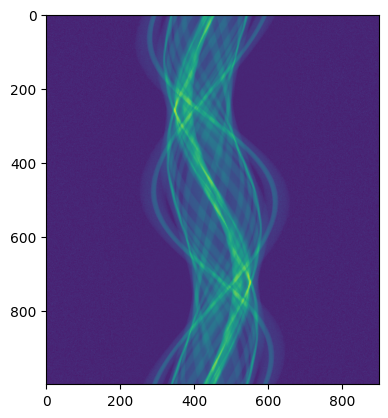

In [ ]:
prep = xc.rawread(ct.resultsName+'.prep', [ct.protocol.viewCount, ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
prep = prep[:, 5, :]
plt.imshow(prep)

In [ ]:
import reconstruction.pyfiles.recon as recon

In [ ]:
ct.cfg.recon.displayImagePictures = True

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


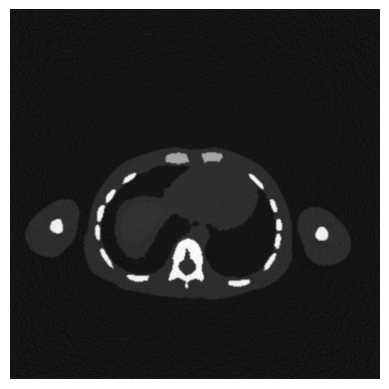

* Saving the recon results to individual .png files...


In [ ]:
ct.cfg.waitForKeypress=False
ct.cfg.do_Recon = True
ct.cfg.recon.fov = 250
recon.recon(ct.cfg)

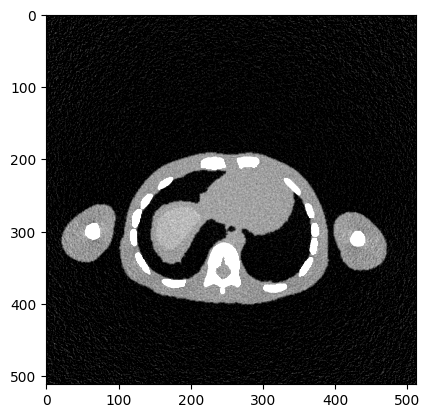

In [ ]:
prep = xc.rawread('male_infant_test_512x512x1.raw',[512,512,1] ,'float')
plt.imshow(prep, cmap='gray', vmin=-1000, vmax=-950)